Author: Alex Allauzen




# Importing libraries

In [7]:
#######################################################
# Useful imports, preliminary commands, etc
#######################################################
import sys
import os
# Numpy and maths
import math
import numpy as np
# torch
import torch as th 
import torch.nn as nn 
from torch.nn  import functional as F 

# Lorenz generator
from lorenz_map import LorenzMap, scatterGraph

# Matplotlib and figures-related commands
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# figs helpers
from fig_utils import *
from ode_utils import *
sns.color_palette("bright")

%matplotlib inline

# Loading the data

In [28]:
fname="datasets/dataset1.np"
f = open(fname, 'rb') 
data = np.load(f)
T,d = data.shape
print(T,d)


5000 3


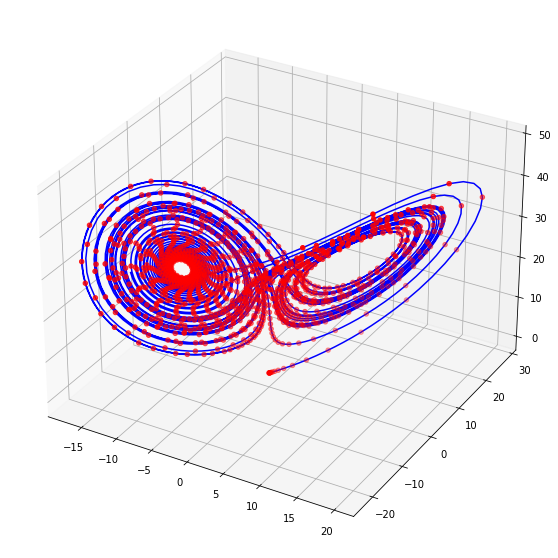

In [3]:
scatterGraph(data,mark_downsampling=4)

In [4]:
obs = th.DoubleTensor(data) # data in torch
T , d = obs.shape # number of time steps, dimension (=3)
print(T,d)
times_np = np.linspace(0,T-1,T)
print(times_np.shape)
z0 = obs[0]
times = th.from_numpy(times_np).to(z0)
print(times.shape)
print(times[-5:])

5000 3
(5000,)
torch.Size([5000])
tensor([4995., 4996., 4997., 4998., 4999.], dtype=torch.float64)


In [12]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
obs = obs.to(device)
z0 = z0.to(device)
times = times.to(device)
print("running on ", device)
Y = obs[1:]

running on  cpu


# LBFGS


## Batch training with Fehlberg method

In [8]:
def batch_training_lbfgs(m, trainset, lr0=1, nsteps=1, nepoch=20,eps=0.1): 
    T,d = trainset.shape
    print("Train shape", T,d)
    optimizer = th.optim.LBFGS(m.parameters(),lr=lr0,max_iter=20,line_search_fn='strong_wolfe')
    losses=th.zeros(nepoch)
    accepted=th.zeros(nepoch)
    hprimes=th.ones(nepoch) # for the rejected part
    Y = trainset[1:] # take the labels associated with the output
    X = trainset[:-1]
    nprint=10
    for e in range(nepoch): 
        def closure():
            optimizer.zero_grad()
            # Fehlberg inference
            bA1, bA2, br, bhp = fehlberg_batch_inference(m, 
                                                        X,
                                                        h=1,
                                                        eps=eps)
            # Update the model with the accepted part 
            sel = br<eps # The accepted part     
            accepted[e] = sel.detach().sum()
            nrejected = (~sel).detach().sum()
            loss = F.mse_loss(bA2[sel],Y[sel],reduction='sum')/(T-1)
            if nrejected > 0: 
                rhp = bhp[~sel].detach()
                hprimes[e] = rhp.min()
                rnsteps = int(th.ceil(1/hprimes[e]).item())
                _ , bA2, _ , _ = fehlberg_batch_inference(m, X,h=1/rnsteps,eps=eps,numsteps=rnsteps)
                loss = loss + F.mse_loss(bA2[~sel],Y[~sel],reduction='sum')/(T-1)
            loss.backward()
            losses[e] = loss.item()
            return loss
        ls=optimizer.step(closure)
        optimizer.zero_grad()
        losses[e] = ls.item() 
        if (e%(nepoch//nprint)) == 0:
            print(e, losses[e].item(), accepted[e].item(), hprimes[e].item())
    return losses , accepted , hprimes


In [9]:
m = ODENet(3,50).double()
l, na, hp = batch_training_lbfgs(m, obs, lr0=0.5, nepoch=200, eps=0.1)

Train shape 5000 3
0 3.362065315246582 4999.0 1.0
20 0.0029497097712010145 4999.0 0.8956869840621948
40 0.0016766401240602136 4998.0 0.7755600214004517
60 0.0011644638143479824 4999.0 1.0
80 0.0008400817750953138 4999.0 1.0
100 0.000753640488255769 4998.0 0.8999999761581421
120 0.000753640488255769 4998.0 0.8999999761581421
140 0.000753640488255769 4998.0 0.8999999761581421
160 0.000753640488255769 4998.0 0.8999999761581421
180 0.000753640488255769 4998.0 0.8999999761581421


It looks like this experiment is quite sensitive to lr0 ! We need to lower it. 
However, even with low lr0, we get stucked in to relatively high training loss 

In [10]:
m1 , l1 , na1 , hp1 = m, l, na, hp

./figs/batch_training.pdf already exists. Move it or change the file name


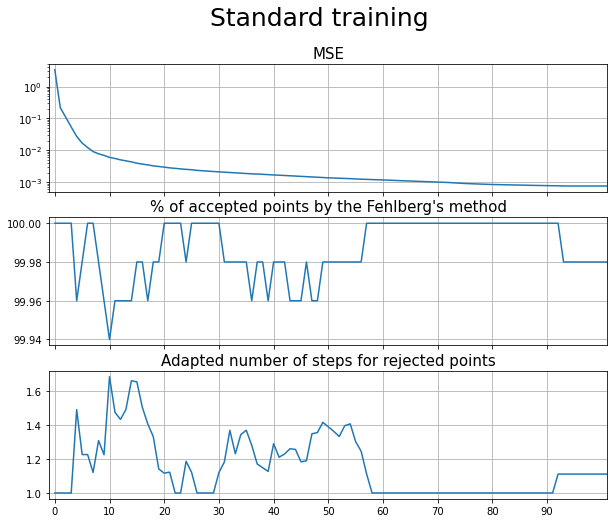

In [11]:
fig, axs = plt.subplots(3,1,figsize=(10,8),sharex=True)
axs[0].set_title("MSE",fontsize=15)
axs[0].set_xlim(-1,101)
axs[0].plot(l1,label="MSE loss evolution")
axs[0].semilogy()
axs[1].set_title("% of accepted points by the Fehlberg's method",fontsize=15)
axs[1].plot(100*na1/(T-1))
axs[2].set_title("Adapted number of steps for rejected points",fontsize=15)
axs[2].plot(1/hp1)
for ax in axs:
    ax.grid()
    ax.xaxis.set_ticks(np.arange(0,100,10))
fig.suptitle("Standard training",fontsize=25)

fname="./figs/batch_training.pdf"
savefig(fname, format="pdf")

In [245]:
import pickle
if False: 
    # Saving the model and results
    file = open('./models/baseline_training_results.pck', 'wb')

    # dump information to that file
    data = (m1 , l1 , na1 , hp1)
    pickle.dump(data, file)

    # close the file
    file.close() 

## Epsilon variation


Train shape 5000 3
0 10.329261779785156 4999.0 0.7675361633300781
20 0.0025214003399014473 4983.0 0.5695585012435913
40 0.0012828648323193192 4984.0 0.4768628776073456
60 0.0008989578927867115 4990.0 0.5237600803375244
80 0.0006937400903552771 4990.0 0.7106291055679321
100 0.0005509197944775224 4996.0 0.7676914930343628
120 0.0005387853016145527 4995.0 0.7650601267814636
140 0.0005387853016145527 4995.0 0.7650601267814636
160 0.0005387853016145527 4995.0 0.7650601267814636
180 0.0005387853016145527 4995.0 0.7650601267814636


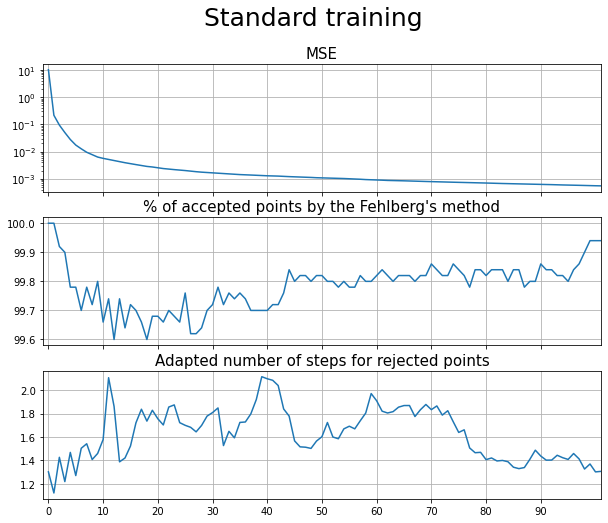

In [253]:
m = ODENet(3,50).double()
l2, na2, hp2 = batch_training_lbfgs(m, obs, lr0=0.5, nepoch=200, eps=0.05)

fig, axs = plt.subplots(3,1,figsize=(10,8),sharex=True)
axs[0].set_title("MSE",fontsize=15)
axs[0].set_xlim(-1,101)
axs[0].plot(l2,label="MSE loss evolution")
axs[0].semilogy()
axs[1].set_title("% of accepted points by the Fehlberg's method",fontsize=15)
axs[1].plot(100*na2/(T-1))
axs[2].set_title("Adapted number of steps for rejected points",fontsize=15)
#axs[2].yaxis.set_ticks(np.arange(1,9,1))
#axs[2].set_ylim(0.5,7.5)
axs[2].plot(1/hp2)
for ax in axs:
    ax.grid()
    ax.xaxis.set_ticks(np.arange(0,100,10))
#fig.tight_layout()
_ = fig.suptitle("Standard training",fontsize=25)
savefig("./figs/baseline_eps0.05.pdf",format="pdf")

In [265]:
m2 = ODENet(3,50).double()
l2, na2, hp2 = batch_training_lbfgs(m2, obs, lr0=0.5, nepoch=200, eps=0.01)

Train shape 5000 3
0 8.940363883972168 4959.0 0.5463374853134155
20 0.0031888692174106836 4467.0 0.22998803853988647
40 0.0015541206812486053 4494.0 0.2533092200756073
60 0.0010295140091329813 4509.0 0.2638801038265228
80 0.0007700155838392675 4531.0 0.25184473395347595
100 0.0006395808304660022 4528.0 0.2565258741378784
120 0.0005644508055411279 4534.0 0.24322578310966492
140 0.0005092736100777984 4550.0 0.26222583651542664
160 0.00045422144467011094 4534.0 0.26658377051353455
180 0.00045422144467011094 4533.0 0.26658377051353455


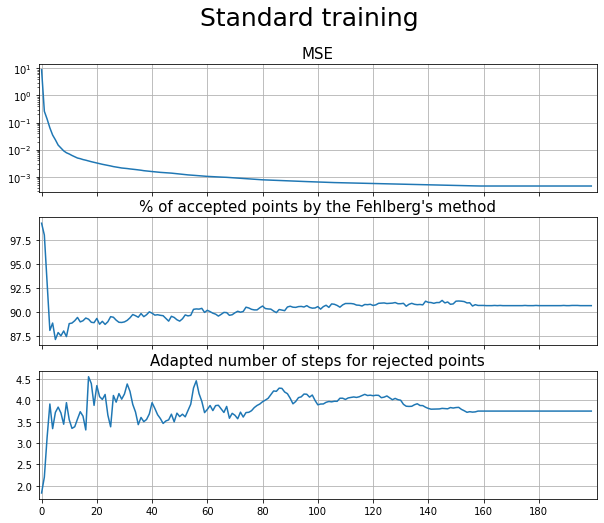

In [266]:
fig, axs = plt.subplots(3,1,figsize=(10,8),sharex=True)
axs[0].set_title("MSE",fontsize=15)
axs[0].set_xlim(-1,201)
axs[0].plot(l2,label="MSE loss evolution")
axs[0].semilogy()
axs[1].set_title("% of accepted points by the Fehlberg's method",fontsize=15)
axs[1].plot(100*na2/(T-1))
axs[2].set_title("Adapted number of steps for rejected points",fontsize=15)
#axs[2].yaxis.set_ticks(np.arange(1,9,1))
#axs[2].set_ylim(0.5,7.5)
axs[2].plot(1/hp2)
for ax in axs:
    ax.grid()
    ax.xaxis.set_ticks(np.arange(0,200,20))
#fig.tight_layout()
_ = fig.suptitle("Standard training",fontsize=25)
savefig("./figs/baseline_eps0.01.pdf",format="pdf")

In [267]:
zpred2, ns2 =generate_fehlberg(obs[0],m2,Ntimes=T)
zpred2, ns2 = zpred2.detach().numpy(), ns2.detach().numpy() 

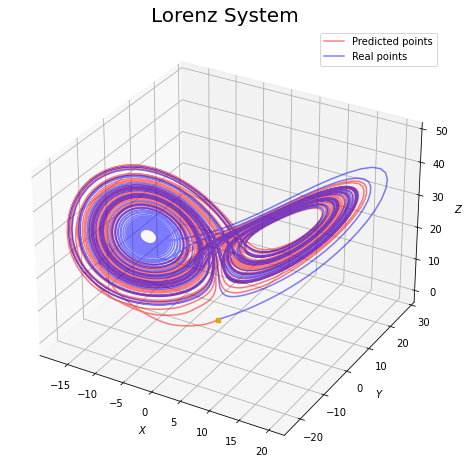

In [272]:
data = obs.detach().numpy()
plot3D_compare(zpred2,data)
savefig("./figs/batch_lorenz_eps_0.01_lorenz.pdf", format="pdf")
plt.show()

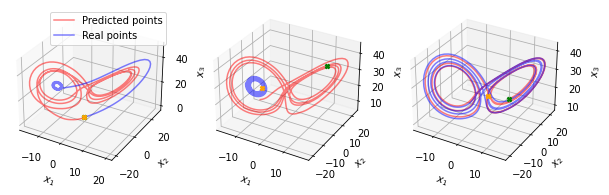

In [275]:
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
MIN , MAX = 0 , 600 
_ = ax_3D(ax,zpred2[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax.legend()
ax = fig.add_subplot(1, 3, 2, projection='3d')
MIN , MAX = 600, 1200 
_ = ax_3D(ax,zpred2[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax = fig.add_subplot(1, 3, 3, projection='3d')
MIN , MAX = 2000, 2600 
_ = ax_3D(ax,zpred2[MIN:MAX],data[MIN:MAX],markers=False, title="")

#fig.suptitle("Learning Lorenz'63",fontsize=15)

savefig("./figs/batch_lorenz_eps_0.01_lorenz_3.pdf", format="pdf")
plt.show()


In [278]:
m2 = ODENet(3,50).double()
l2, na2, hp2 = batch_training_lbfgs(m2, obs, lr0=0.5, nepoch=300, eps=0.005)

Train shape 5000 3
0 8.376748085021973 4820.0 0.38602644205093384
30 0.002325408160686493 3895.0 0.1948889195919037
60 0.001452006632462144 3893.0 0.17096872627735138
90 0.0010093633318319917 3874.0 0.20566870272159576
120 0.0007338224095292389 3886.0 0.2138873189687729
150 0.0006440334836952388 3889.0 0.2417566031217575
180 0.0005857069627381861 3890.0 0.20791740715503693
210 0.000567591458093375 3888.0 0.21019001305103302
240 0.000567591458093375 3889.0 0.21019001305103302
270 0.000567591458093375 3889.0 0.21019001305103302


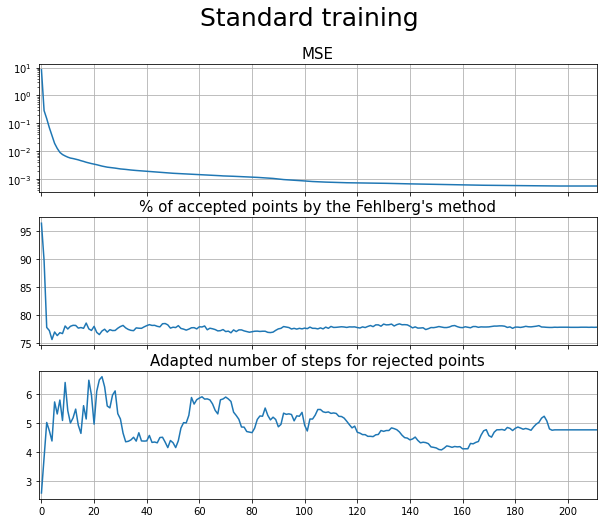

In [281]:
fig, axs = plt.subplots(3,1,figsize=(10,8),sharex=True)
axs[0].set_title("MSE",fontsize=15)
axs[0].set_xlim(-1,211)
axs[0].plot(l2,label="MSE loss evolution")
axs[0].semilogy()
axs[1].set_title("% of accepted points by the Fehlberg's method",fontsize=15)
axs[1].plot(100*na2/(T-1))
axs[2].set_title("Adapted number of steps for rejected points",fontsize=15)
#axs[2].yaxis.set_ticks(np.arange(1,9,1))
#axs[2].set_ylim(0.5,7.5)
axs[2].plot(1/hp2)
for ax in axs:
    ax.grid()
    ax.xaxis.set_ticks(np.arange(0,210,20))
#fig.tight_layout()
_ = fig.suptitle("Standard training",fontsize=25)
psavefig("./figs/baseline_eps0.005.pdf",format="pdf")

## Fehlberg training 

In [12]:
def fehlberg_batch_training_lbfgs(m, trainset, lr0=1, nsteps=1, 
                                  h=1, nepoch=20,eps=0.1,S=0.9,
                                    nprint=20
                                 ): 
    T,d = trainset.shape
    print("Train shape", T,d)
    optimizer = th.optim.LBFGS(m.parameters(),lr=lr0,max_iter=20,line_search_fn='strong_wolfe')
    losses=th.zeros(nepoch)
    accepted=th.zeros(nepoch)
    hprimes=th.zeros(nepoch) # predicted step for the rejected part
    Y = trainset[1:] # take the labels associated with the output
    for e in range(nepoch):
        ###################################################
        def loss_closure():
            optimizer.zero_grad()
            # Fehlberg inference
            preds = rk3(m,trainset)[:-1]
            errors = (th.abs(preds-Y).sum(dim=1)/h).detach()
            # Update the model with the accepted part 
            sel = errors<eps # The accepted part  
            hprime = h*S*(eps/errors)**(0.5)
            accepted[e] = sel.sum()
            rejectedHP = hprime[~sel]
            hprimes[e] = 1 
            loss = F.mse_loss(preds[sel],Y[sel],reduction='sum')/(T-1)
            if accepted[e] < (T-2):
                # We take the min of h' (new step size)
                # => the max number of steps. 
                hprimes[e] = rejectedHP.min()
                rnsteps = int(th.ceil(1/hprimes[e]).item())
                npreds = rk3(m, obs,h=1/rnsteps,numsteps=rnsteps)[:-1]
                loss = loss + F.mse_loss(
                    npreds[~sel],
                    Y[~sel],reduction='sum'
                    )/(T-1)
            loss.backward()
            return loss
        ######################################################
        ls=optimizer.step(loss_closure)
        optimizer.zero_grad()
        losses[e] = ls.item() 
        if (e%(nepoch//nprint)) == 0:
            print(e, losses[e].item(), accepted[e].item(), hprimes[e].item())
    return losses , accepted , hprimes


In [15]:
m3 = ODENet(3,50).double()
l3, na3, hp3 = fehlberg_batch_training_lbfgs(m3, obs,lr0=1, nepoch=200, eps=0.1)

Train shape 5000 3
0 3.1862576007843018 140.0 0.14805234968662262
10 0.006974624469876289 3642.0 0.28511467576026917
20 0.0029209409840404987 4436.0 0.3787239193916321
30 0.0020161739084869623 4677.0 0.38641098141670227
40 0.0015011418145149946 4806.0 0.46403005719184875
50 0.0012049319921061397 4856.0 0.4713818430900574
60 0.0009560097241774201 4889.0 0.45408281683921814
70 0.0007864860817790031 4932.0 0.45939597487449646
80 0.0006573531427420676 4949.0 0.49444079399108887
90 0.0005709532997570932 4967.0 0.5412488579750061
100 0.0005008166190236807 4970.0 0.5853764414787292
110 0.00045725805102847517 4970.0 0.5983620285987854
120 0.00042021984700113535 4976.0 0.6237769722938538
130 0.0003882940800394863 4983.0 0.7519225478172302
140 0.00036541992449201643 4981.0 0.7261807322502136
150 0.000360615347744897 4984.0 0.7184869647026062
160 0.000360615347744897 4984.0 0.7184869647026062
170 0.000360615347744897 4984.0 0.7184869647026062
180 0.000360615347744897 4984.0 0.7184869647026062
190

In [19]:
l3s, na3s, hp3s, m3s = l3, na3, hp3, m3
# Saving the model and results
if False: 
    file = open('./models/fehlberg_training_results.pck', 'wb')
    # dump information to that file
    results = (m3s , l3s , na3s , hp3s)
    pickle.dump(results, file)

    # close the file
    file.close() 

In [20]:
zpred3, ns3 =generate_fehlberg(obs[0],m3s,Ntimes=T)


In [21]:
zpred3, ns3 = zpred3.detach().numpy(), ns3.detach().numpy() 

./figs/fehlberg2_lorenz.pdf already exists. Move it or change the file name


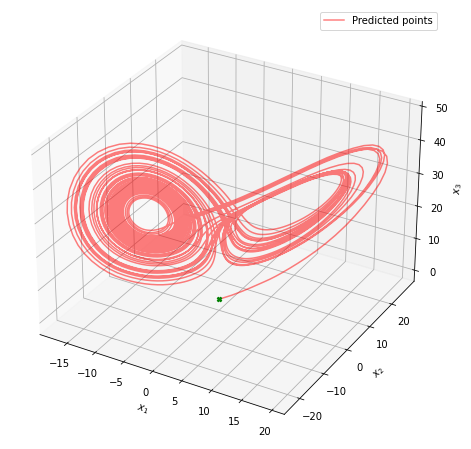

In [22]:
plot3D_compare(zpred3)
savefig("./figs/fehlberg2_lorenz.pdf", format="pdf")
plt.show()

Save fig in ./figs/fehlberg_training.pdf


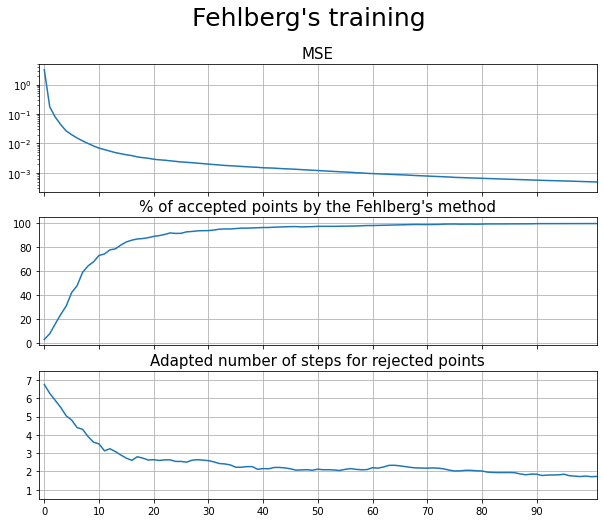

In [23]:
fig, axs = plt.subplots(3,1,figsize=(10,8),sharex=True)
axs[0].set_title("MSE",fontsize=15)
axs[0].set_xlim(-1,101)
axs[0].plot(l3s)
axs[0].semilogy()
axs[1].set_title("% of accepted points by the Fehlberg's method",fontsize=15)
axs[1].plot(100*na3s/(T-1))
axs[2].yaxis.set_ticks(np.arange(1,9,1))
axs[2].set_ylim(0.5,7.5)
axs[2].plot(1/hp3s)
axs[2].set_title("Adapted number of steps for rejected points",fontsize=15)
for ax in axs:
    ax.grid()
    ax.xaxis.set_ticks(np.arange(0,100,10))
#fig.tight_layout()
fig.suptitle("Fehlberg's training",fontsize=25)


fname="./figs/fehlberg_training.pdf"
savefig(fname, format="pdf")

./figs/fehlberg_lorenz_3.pdf already exists. Move it or change the file name


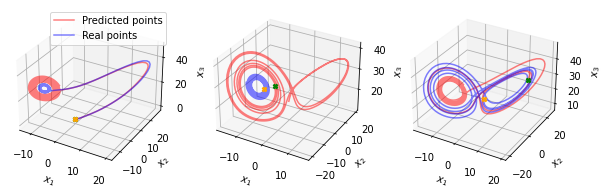

In [29]:
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
MIN , MAX = 0 , 600 
_ = ax_3D(ax,zpred3[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax.legend()
ax = fig.add_subplot(1, 3, 2, projection='3d')
MIN , MAX = 600, 1200 
_ = ax_3D(ax,zpred3[MIN:MAX],data[MIN:MAX],markers=False, title="")
ax = fig.add_subplot(1, 3, 3, projection='3d')
MIN , MAX = 2000, 2600 
_ = ax_3D(ax,zpred3[MIN:MAX],data[MIN:MAX],markers=False, title="")

#fig.suptitle("Learning Lorenz'63",fontsize=15)

savefig("./figs/fehlberg_lorenz_3.pdf", format="pdf")
plt.show()